<a href="https://colab.research.google.com/github/R-Madhuram/DartmouthCapstone_CrudeOilPricePrediction/blob/main/copy_2_SARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [ ]:
#import libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style='whitegrid')
sns.set_context(context='paper',font_scale=1.5)
%matplotlib inline

#import utilities as util

#ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from statsmodels.tsa.stattools import adfuller
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa import arima_process


from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.linear_model import LinearRegression, ElasticNet,Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error
import io

import itertools


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# load data
us_cushing = pd.read_csv('/content/drive/MyDrive/PCDS_OilPricePrediction/data/USCushing.csv')
eu_brent = pd.read_csv('/content/drive/MyDrive/PCDS_OilPricePrediction/data/EuropeanBrent.csv')


## Cushing Data

In [ ]:
# Read data 
us_cushing.head().append(us_cushing.tail())

,Date,"Cushing, OK WTI Spot Price FOB (Dollars per Barrel)"
0,"Jan 02, 1986",25.56
1,"Jan 03, 1986",26.00
2,"Jan 06, 1986",26.53
3,"Jan 07, 1986",25.85
4,"Jan 08, 1986",25.87
9357,"Feb 22, 2023",73.95
9358,"Feb 23, 2023",75.26
9359,"Feb 24, 2023",76.19
9360,"Feb 27, 2023",75.57
9361,NaN,NaN


## Brent Data

In [ ]:
# Read data
eu_brent.head().append(eu_brent.tail())

,Date,Europe Brent Spot Price FOB (Dollars per Barrel)
0,"May 20, 1987",18.63
1,"May 21, 1987",18.45
2,"May 22, 1987",18.55
3,"May 25, 1987",18.60
4,"May 26, 1987",18.63
9077,"Feb 22, 2023",79.55
9078,"Feb 23, 2023",82.08
9079,"Feb 24, 2023",82.31
9080,"Feb 27, 2023",82.31
9081,NaN,NaN


# Creating dataframe with date as index and changing date as date-time object

## Cushing Data

In [ ]:
# Convert the date to dateimte object 
us_cushing['Date'] = pd.to_datetime(us_cushing['Date'], format = '%b %d, %Y')

In [ ]:
print(us_cushing['Date'].dtype)

datetime64[ns]


In [ ]:
# rename price column
us_cushing.rename(columns={'Cushing, OK WTI Spot Price FOB (Dollars per Barrel)':'price'},inplace=True)

In [ ]:
cushing_df = us_cushing

In [ ]:
cushing_df = cushing_df[:-1]
cushing_df

,Date,price
0,1986-01-02,25.56
1,1986-01-03,26.00
2,1986-01-06,26.53
3,1986-01-07,25.85
4,1986-01-08,25.87
...,...,...
9356,2023-02-21,76.28
9357,2023-02-22,73.95
9358,2023-02-23,75.26
9359,2023-02-24,76.19


In [ ]:
# Change the index of the Df as date index
# cushing_df.index = pd.date_range(start='01-02-1986', end='02-27-2023', freq='D')
cushing_df = cushing_df.set_index('Date')

In [ ]:
cushing_df.index = pd.DatetimeIndex(cushing_df.index).to_period('D')
cushing_df

,price
Date,
1986-01-02,25.56
1986-01-03,26.00
1986-01-06,26.53
1986-01-07,25.85
1986-01-08,25.87
...,...
2023-02-21,76.28
2023-02-22,73.95
2023-02-23,75.26


## Brent Data

In [ ]:
# Convert the date to dateimte object 
eu_brent['Date'] = pd.to_datetime(eu_brent['Date'], format = '%b %d, %Y')

In [ ]:
print(eu_brent['Date'].dtype)

datetime64[ns]


In [ ]:
# rename price column
eu_brent.rename(columns={'Europe Brent Spot Price FOB (Dollars per Barrel)':'price'},inplace=True)
eu_brent

,Date,price
0,1987-05-20,18.63
1,1987-05-21,18.45
2,1987-05-22,18.55
3,1987-05-25,18.60
4,1987-05-26,18.63
...,...,...
9077,2023-02-22,79.55
9078,2023-02-23,82.08
9079,2023-02-24,82.31
9080,2023-02-27,82.31


In [ ]:
brent_df = eu_brent
brent_df = brent_df[:-1]

In [ ]:
# Change the index of the Df as date index
# brent_df.index = pd.date_range(start='05-20-1987', end='02-27-2023', freq='D')
brent_df = brent_df.set_index('Date')

In [ ]:
brent_df.index = pd.DatetimeIndex(brent_df.index).to_period('D')
brent_df

,price
Date,
1987-05-20,18.63
1987-05-21,18.45
1987-05-22,18.55
1987-05-25,18.60
1987-05-26,18.63
...,...
2023-02-21,82.14
2023-02-22,79.55
2023-02-23,82.08


# Time Series Plot 

## Cushing Data

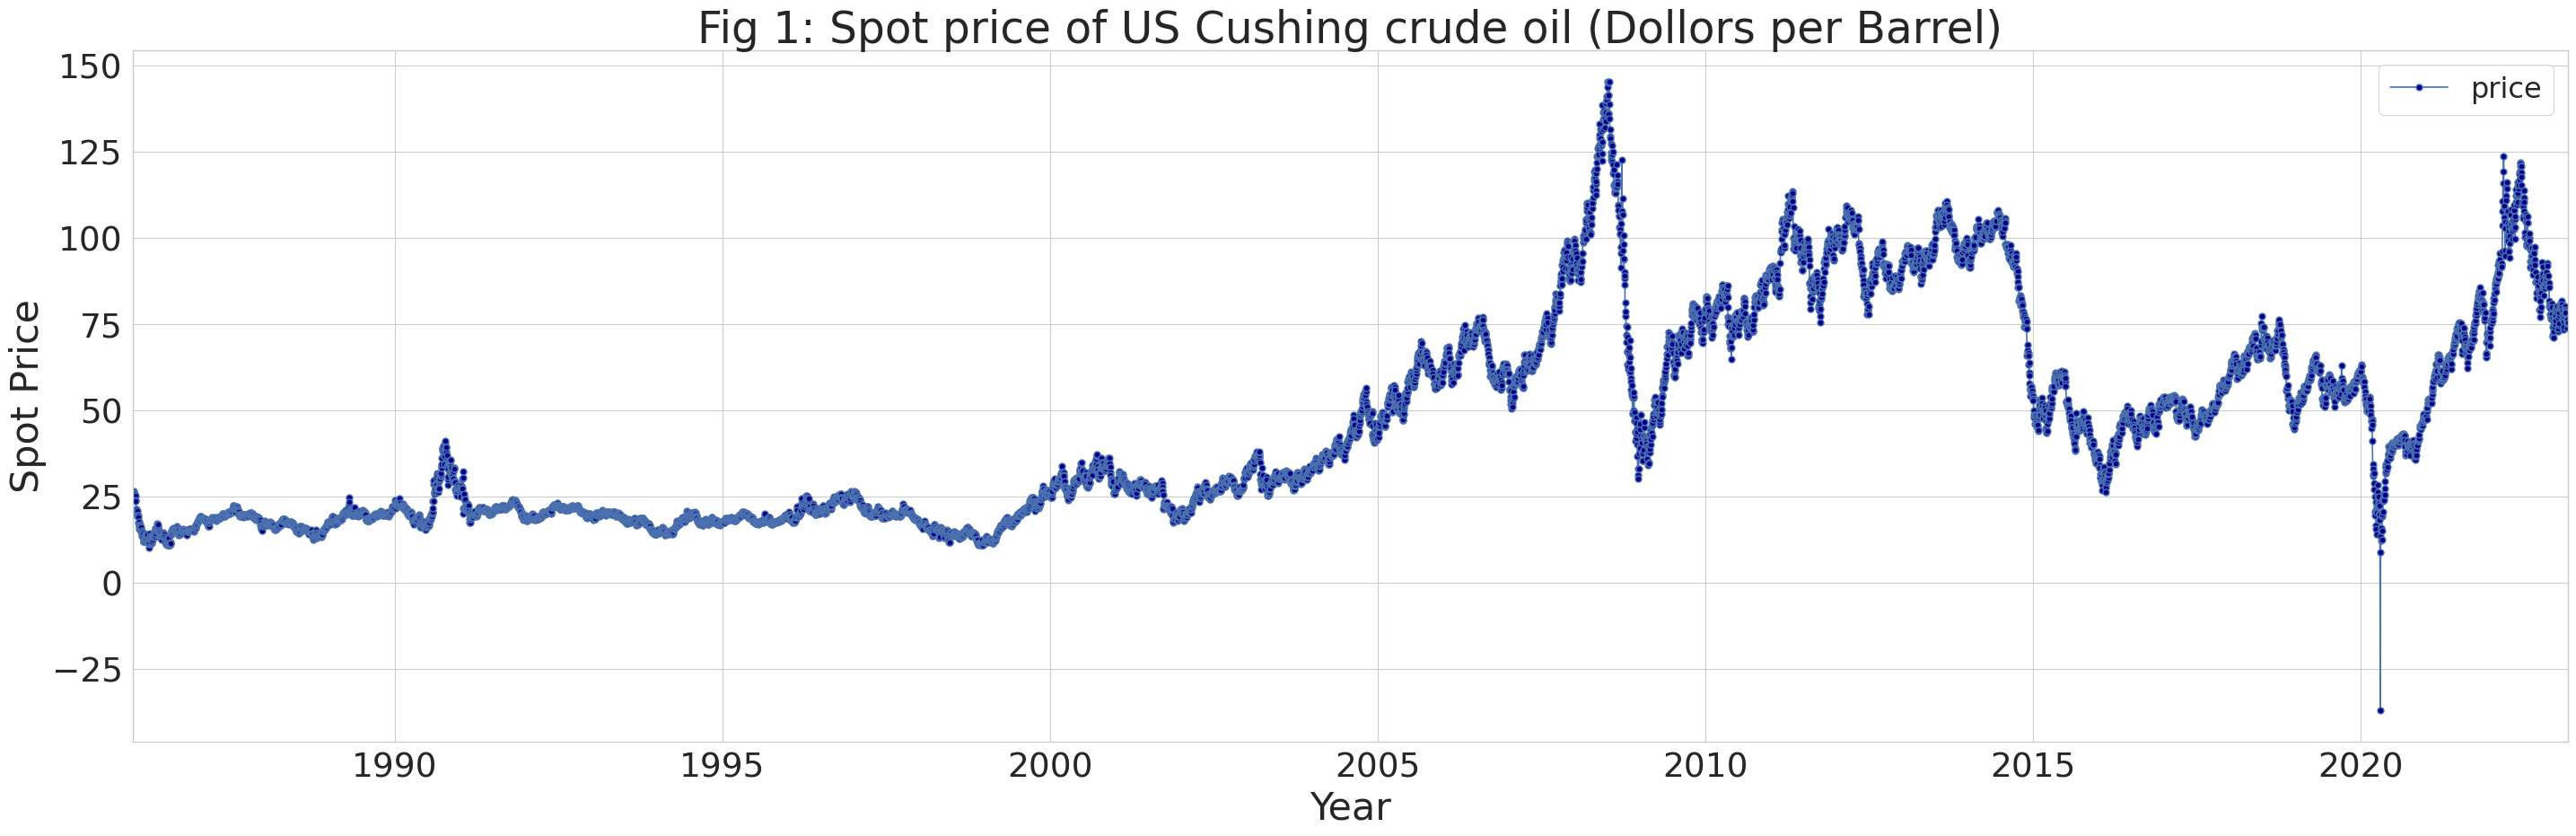

In [ ]:
# Time Series Plot of the Cushing data
fig_1 = cushing_df.squeeze().plot(figsize=(35,10),markersize=10, markerfacecolor= 'darkblue',marker='.',grid=True)
plt.legend(fontsize=23)
plt.title("Fig 1: Spot price of US Cushing crude oil (Dollors per Barrel)",fontsize=35)
plt.xlabel("Year", fontsize=31)
plt.ylabel("Spot Price",fontsize=31)
plt.xticks(fontsize=27)
plt.yticks(fontsize=27)
plt.savefig('fig_1_Cushing_ts.png')

## Brent Data

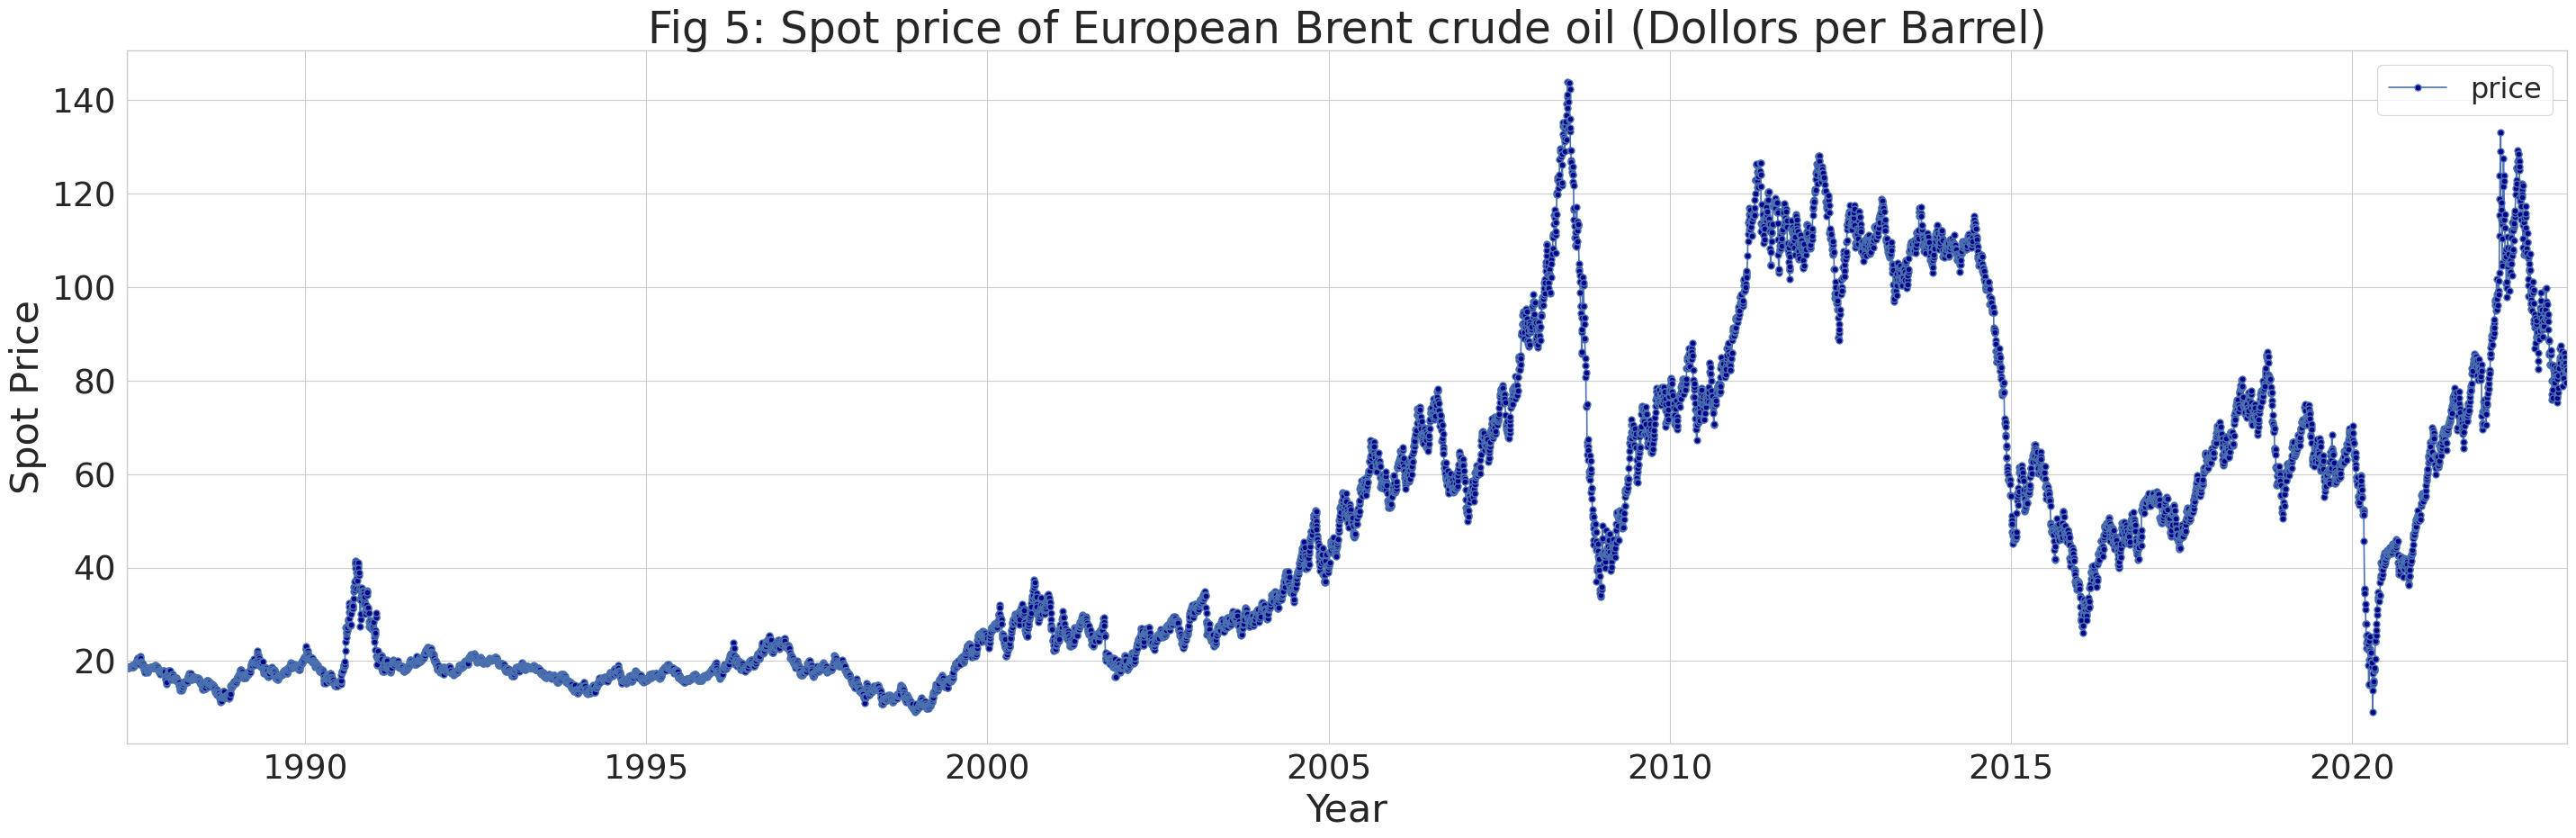

In [ ]:
# Time series plot Eropean Brent crude oil price data
fig_5 = brent_df.squeeze().plot(figsize=(35,10),markersize=10, markerfacecolor= 'darkblue',marker='.',grid=True)
plt.legend(fontsize=23)
plt.title("Fig 5: Spot price of European Brent crude oil (Dollors per Barrel)",fontsize=35)
plt.xlabel("Year", fontsize=31)
plt.ylabel("Spot Price",fontsize=31)
plt.xticks(fontsize=27)
plt.yticks(fontsize=27)
plt.savefig('fig_5_Brent_ts.png')

# Time-Series Analysis of sale price of crude oil

## Cushing Data

### Stationarity of the signal

In [ ]:
# Ad-fuller test to check the stationarity of the signal
cushing_residue_price = adfuller(cushing_df['price'])
ans_cushing = 'stationary' if cushing_residue_price[1] < 0.05 else 'not stationary'
print(cushing_residue_price)
print(ans_cushing)

(-2.3672829066966337, 0.15118424280209147, 38, 9322, {'1%': -3.4310516843596464, '5%': -2.861850100263371, '10%': -2.5669350612883703}, 33326.873143386205)
not stationary


### Use sample partial autocorrelation (PACF) and sample autocorrelation (ACF) function to select order(s) (p,q) of AR and MA process respectively

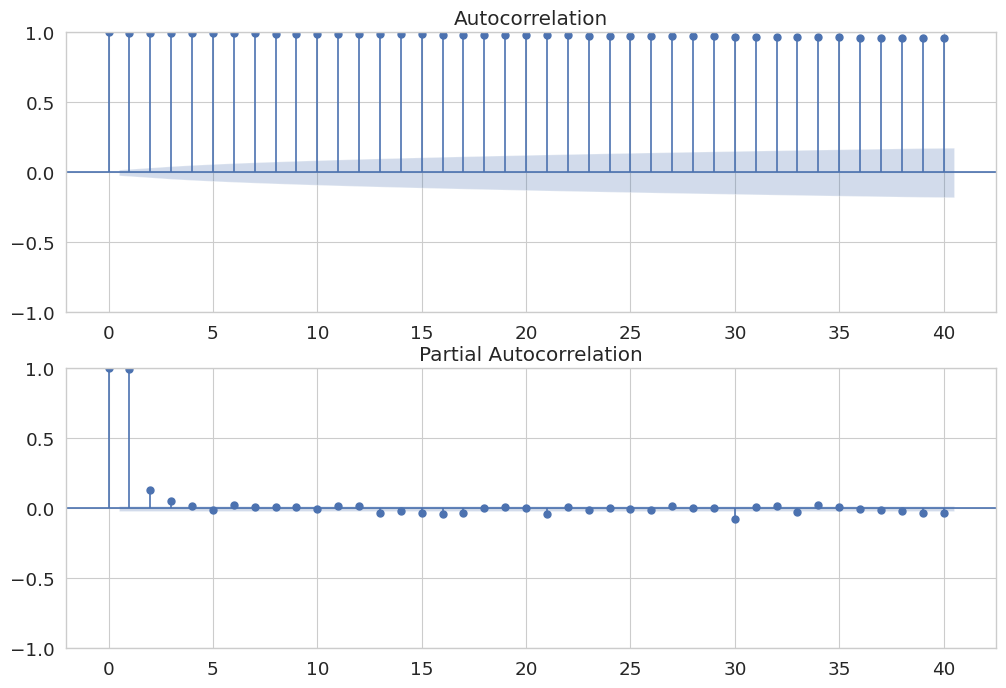

In [ ]:
# ACF and PACF Plots to determine AR and MA process orders
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))
plt.title('Fig 15: ACF and PACF plots of sale Price of US Cushing Crude Oil')
plot_acf(cushing_df.values.squeeze(), ax=ax[0])
plot_pacf(cushing_df.values.squeeze(), ax=ax[1], method='ols')
plt.savefig('fig_15_cushing_ACF_plts.png')

## Brent Data

### Stationarity of the signal

In [ ]:
# Ad-fuller test to check the stationarity of the signal
brent_residue_price = adfuller(brent_df['price'])
ans_brent = 'stationary' if brent_residue_price[1] < 0.05 else 'not stationary'
print(brent_residue_price)
print(ans_brent)

(-2.1078324090273384, 0.24137683641020097, 29, 9051, {'1%': -3.4310726997648144, '5%': -2.8618593866183164, '10%': -2.5669400044583415}, 29239.71867660825)
not stationary


### Use sample partial autocorrelation (PACF) and sample autocorrelation (ACF) function to select order(s) (p,q) of AR and MA process respectively

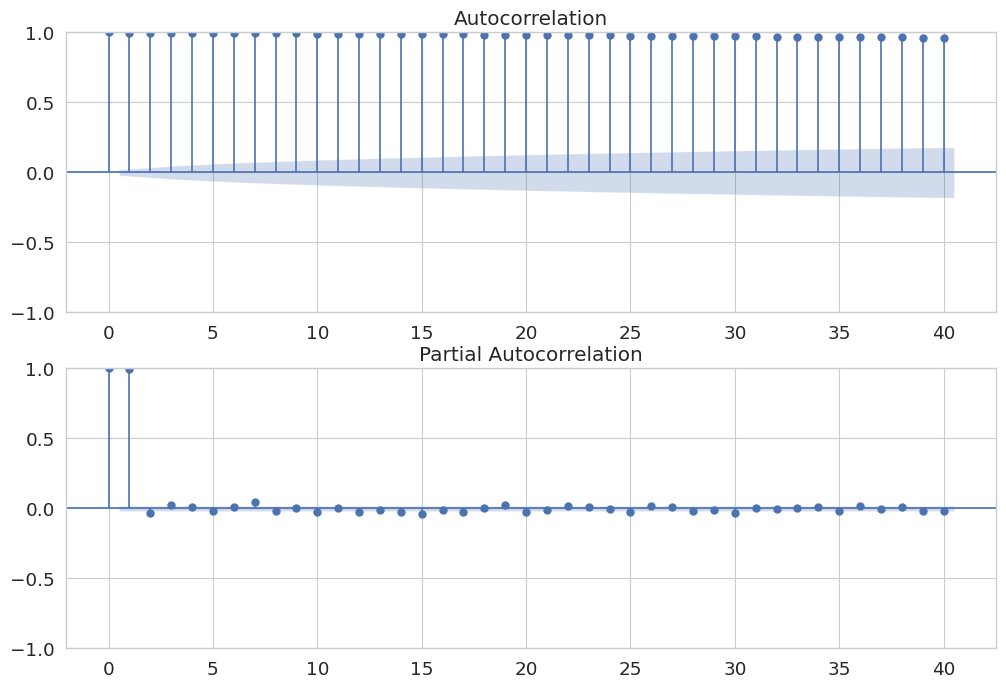

In [ ]:
# ACF and PACF Plots to determine AR and MA process orders
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))
plt.title('Fig 16: ACF and PACF plots of sale Price of European Brent Crude Oil')
plot_acf(brent_df['price'], ax=ax[0])
plot_pacf(brent_df['price'], ax=ax[1], method='ols')
plt.savefig('fig_16_brent_ACF_plts.png')

# Modeling with ARMA Family of models

## Cushing Data

In [ ]:
# split the available data as historical and future for computing forecast error 
cushing_seasonal = cushing_df
# cushing_seasonal.index = cushing_seasonal.index.to_timestamp()
cushing_y_hist = cushing_seasonal.loc['1986':'2021','price'] 
cushing_y_future = cushing_seasonal.loc['2022':, 'price']
cushing_y_hist, cushing_y_future

(Date
 1986-01-02    25.56
 1986-01-03    26.00
 1986-01-06    26.53
 1986-01-07    25.85
 1986-01-08    25.87
               ...  
 2021-12-27    75.49
 2021-12-28    76.01
 2021-12-29    76.58
 2021-12-30    76.83
 2021-12-31    75.33
 Freq: D, Name: price, Length: 9072, dtype: float64,
 Date
 2022-01-03    75.99
 2022-01-04    77.00
 2022-01-05    77.83
 2022-01-06    79.47
 2022-01-07    79.00
               ...  
 2023-02-21    76.28
 2023-02-22    73.95
 2023-02-23    75.26
 2023-02-24    76.19
 2023-02-27    75.57
 Freq: D, Name: price, Length: 289, dtype: float64)

### 0) SARIMA

In [ ]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pmdarima as pm
from pmdarima import model_selection

In [ ]:
# Model to be used for actual prediction
cushing_sarima_model_forPredict = SARIMAX(endog = cushing_y_hist,
                       order=(4, 0, 0),
                       seasonal_order=(0, 1, 1, 12),
                       enforce_stationarity=False,
                       enforce_invertibility=True)
cushing_sarima_results = cushing_sarima_model_forPredict.fit()

In [ ]:
# Model to be used for cross validation score
cushing_sarima_model = pm.arima.ARIMA(endog = cushing_y_hist,
                       order=(4, 0, 0),
                       seasonal_order=(0, 1, 1, 12),
                       enforce_stationarity=False,
                       enforce_invertibility=True)

In [ ]:
# Cross-validation
cushing_cv_sarima = model_selection.SlidingWindowForecastCV(h=22, 
                                                 step=(22),         
                                                 window_size=(253*2)
                                                 )
cushing_cv_score_sarima = model_selection.cross_val_score(estimator = cushing_sarima_model,
                                           y = cushing_y_hist,
                                           scoring = 'mean_squared_error',
                                           cv = cushing_cv_sarima,
                                           verbose = 2,
                                           error_score= 100000000000000000)



[CV] fold=0 ..........................................................
[CV] fold=1 ..........................................................
[CV] fold=2 ..........................................................
[CV] fold=3 ..........................................................


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[CV] fold=4 ..........................................................


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[CV] fold=5 ..........................................................


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[CV] fold=6 ..........................................................
[CV] fold=7 ..........................................................
[CV] fold=8 ..........................................................
[CV] fold=9 ..........................................................
[CV] fold=10 .........................................................
[CV] fold=11 .........................................................
[CV] fold=12 .........................................................
[CV] fold=13 .........................................................
[CV] fold=14 .........................................................
[CV] fold=15 .........................................................
[CV] fold=16 .........................................................
[CV] fold=17 .........................................................
[CV] fold=18 .........................................................
[CV] fold=19 .........................................................
[CV] f

/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[CV] fold=38 .........................................................
[CV] fold=39 .........................................................
[CV] fold=40 .........................................................


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[CV] fold=41 .........................................................


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[CV] fold=42 .........................................................


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[CV] fold=43 .........................................................
[CV] fold=44 .........................................................
[CV] fold=45 .........................................................


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[CV] fold=46 .........................................................


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[CV] fold=47 .........................................................


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[CV] fold=48 .........................................................


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[CV] fold=49 .........................................................


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[CV] fold=50 .........................................................
[CV] fold=51 .........................................................
[CV] fold=52 .........................................................
[CV] fold=53 .........................................................
[CV] fold=54 .........................................................
[CV] fold=55 .........................................................
[CV] fold=56 .........................................................
[CV] fold=57 .........................................................
[CV] fold=58 .........................................................
[CV] fold=59 .........................................................
[CV] fold=60 .........................................................
[CV] fold=61 .........................................................
[CV] fold=62 .........................................................
[CV] fold=63 .........................................................


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[CV] fold=64 .........................................................
[CV] fold=65 .........................................................
[CV] fold=66 .........................................................
[CV] fold=67 .........................................................
[CV] fold=68 .........................................................
[CV] fold=69 .........................................................


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[CV] fold=70 .........................................................
[CV] fold=71 .........................................................


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[CV] fold=72 .........................................................
[CV] fold=73 .........................................................


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[CV] fold=74 .........................................................
[CV] fold=75 .........................................................
[CV] fold=76 .........................................................
[CV] fold=77 .........................................................
[CV] fold=78 .........................................................


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[CV] fold=79 .........................................................
[CV] fold=80 .........................................................
[CV] fold=81 .........................................................


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[CV] fold=82 .........................................................
[CV] fold=83 .........................................................


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[CV] fold=84 .........................................................
[CV] fold=85 .........................................................


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[CV] fold=86 .........................................................


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[CV] fold=87 .........................................................
[CV] fold=88 .........................................................
[CV] fold=89 .........................................................
[CV] fold=90 .........................................................


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[CV] fold=91 .........................................................


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[CV] fold=92 .........................................................
[CV] fold=93 .........................................................
[CV] fold=94 .........................................................
[CV] fold=95 .........................................................
[CV] fold=96 .........................................................
[CV] fold=97 .........................................................
[CV] fold=98 .........................................................
[CV] fold=99 .........................................................
[CV] fold=100 ........................................................


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[CV] fold=101 ........................................................
[CV] fold=102 ........................................................
[CV] fold=103 ........................................................
[CV] fold=104 ........................................................
[CV] fold=105 ........................................................
[CV] fold=106 ........................................................
[CV] fold=107 ........................................................
[CV] fold=108 ........................................................
[CV] fold=109 ........................................................
[CV] fold=110 ........................................................
[CV] fold=111 ........................................................
[CV] fold=112 ........................................................
[CV] fold=113 ........................................................
[CV] fold=114 ........................................................
[CV] f

/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[CV] fold=136 ........................................................
[CV] fold=137 ........................................................


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[CV] fold=138 ........................................................


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[CV] fold=139 ........................................................
[CV] fold=140 ........................................................
[CV] fold=141 ........................................................
[CV] fold=142 ........................................................
[CV] fold=143 ........................................................
[CV] fold=144 ........................................................
[CV] fold=145 ........................................................
[CV] fold=146 ........................................................
[CV] fold=147 ........................................................
[CV] fold=148 ........................................................
[CV] fold=149 ........................................................
[CV] fold=150 ........................................................
[CV] fold=151 ........................................................
[CV] fold=152 ........................................................
[CV] f

/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[CV] fold=191 ........................................................
[CV] fold=192 ........................................................
[CV] fold=193 ........................................................
[CV] fold=194 ........................................................
[CV] fold=195 ........................................................


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[CV] fold=196 ........................................................
[CV] fold=197 ........................................................
[CV] fold=198 ........................................................


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[CV] fold=199 ........................................................
[CV] fold=200 ........................................................
[CV] fold=201 ........................................................
[CV] fold=202 ........................................................
[CV] fold=203 ........................................................
[CV] fold=204 ........................................................
[CV] fold=205 ........................................................


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[CV] fold=206 ........................................................
[CV] fold=207 ........................................................


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[CV] fold=208 ........................................................
[CV] fold=209 ........................................................
[CV] fold=210 ........................................................
[CV] fold=211 ........................................................
[CV] fold=212 ........................................................
[CV] fold=213 ........................................................
[CV] fold=214 ........................................................
[CV] fold=215 ........................................................
[CV] fold=216 ........................................................
[CV] fold=217 ........................................................


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[CV] fold=218 ........................................................
[CV] fold=219 ........................................................
[CV] fold=220 ........................................................
[CV] fold=221 ........................................................
[CV] fold=222 ........................................................
[CV] fold=223 ........................................................
[CV] fold=224 ........................................................
[CV] fold=225 ........................................................


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[CV] fold=226 ........................................................
[CV] fold=227 ........................................................
[CV] fold=228 ........................................................
[CV] fold=229 ........................................................
[CV] fold=230 ........................................................
[CV] fold=231 ........................................................
[CV] fold=232 ........................................................
[CV] fold=233 ........................................................


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[CV] fold=234 ........................................................
[CV] fold=235 ........................................................


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[CV] fold=236 ........................................................
[CV] fold=237 ........................................................
[CV] fold=238 ........................................................
[CV] fold=239 ........................................................
[CV] fold=240 ........................................................
[CV] fold=241 ........................................................
[CV] fold=242 ........................................................


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[CV] fold=243 ........................................................
[CV] fold=244 ........................................................
[CV] fold=245 ........................................................
[CV] fold=246 ........................................................
[CV] fold=247 ........................................................
[CV] fold=248 ........................................................


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[CV] fold=249 ........................................................
[CV] fold=250 ........................................................
[CV] fold=251 ........................................................
[CV] fold=252 ........................................................
[CV] fold=253 ........................................................
[CV] fold=254 ........................................................
[CV] fold=255 ........................................................
[CV] fold=256 ........................................................
[CV] fold=257 ........................................................
[CV] fold=258 ........................................................
[CV] fold=259 ........................................................
[CV] fold=260 ........................................................
[CV] fold=261 ........................................................
[CV] fold=262 ........................................................
[CV] f

/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[CV] fold=275 ........................................................


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[CV] fold=276 ........................................................


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[CV] fold=277 ........................................................


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[CV] fold=278 ........................................................
[CV] fold=279 ........................................................


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[CV] fold=280 ........................................................
[CV] fold=281 ........................................................
[CV] fold=282 ........................................................
[CV] fold=283 ........................................................
[CV] fold=284 ........................................................
[CV] fold=285 ........................................................
[CV] fold=286 ........................................................
[CV] fold=287 ........................................................
[CV] fold=288 ........................................................
[CV] fold=289 ........................................................


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[CV] fold=290 ........................................................
[CV] fold=291 ........................................................
[CV] fold=292 ........................................................
[CV] fold=293 ........................................................
[CV] fold=294 ........................................................
[CV] fold=295 ........................................................
[CV] fold=296 ........................................................
[CV] fold=297 ........................................................


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[CV] fold=298 ........................................................
[CV] fold=299 ........................................................
[CV] fold=300 ........................................................
[CV] fold=301 ........................................................
[CV] fold=302 ........................................................
[CV] fold=303 ........................................................
[CV] fold=304 ........................................................
[CV] fold=305 ........................................................
[CV] fold=306 ........................................................
[CV] fold=307 ........................................................
[CV] fold=308 ........................................................
[CV] fold=309 ........................................................
[CV] fold=310 ........................................................
[CV] fold=311 ........................................................
[CV] f

/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[CV] fold=313 ........................................................
[CV] fold=314 ........................................................
[CV] fold=315 ........................................................
[CV] fold=316 ........................................................
[CV] fold=317 ........................................................
[CV] fold=318 ........................................................
[CV] fold=319 ........................................................
[CV] fold=320 ........................................................


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[CV] fold=321 ........................................................


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[CV] fold=322 ........................................................
[CV] fold=323 ........................................................
[CV] fold=324 ........................................................
[CV] fold=325 ........................................................
[CV] fold=326 ........................................................


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[CV] fold=327 ........................................................
[CV] fold=328 ........................................................
[CV] fold=329 ........................................................
[CV] fold=330 ........................................................
[CV] fold=331 ........................................................
[CV] fold=332 ........................................................
[CV] fold=333 ........................................................
[CV] fold=334 ........................................................
[CV] fold=335 ........................................................


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[CV] fold=336 ........................................................
[CV] fold=337 ........................................................
[CV] fold=338 ........................................................
[CV] fold=339 ........................................................
[CV] fold=340 ........................................................
[CV] fold=341 ........................................................
[CV] fold=342 ........................................................
[CV] fold=343 ........................................................
[CV] fold=344 ........................................................
[CV] fold=345 ........................................................
[CV] fold=346 ........................................................
[CV] fold=347 ........................................................
[CV] fold=348 ........................................................
[CV] fold=349 ........................................................
[CV] f

/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[CV] fold=376 ........................................................


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[CV] fold=377 ........................................................
[CV] fold=378 ........................................................


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[CV] fold=379 ........................................................


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[CV] fold=380 ........................................................


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[CV] fold=381 ........................................................


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[CV] fold=382 ........................................................


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[CV] fold=383 ........................................................


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[CV] fold=384 ........................................................
[CV] fold=385 ........................................................


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[CV] fold=386 ........................................................


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[CV] fold=387 ........................................................
[CV] fold=388 ........................................................


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
# Making predictions on the training data

cushing_df_series = cushing_df.squeeze()
date_index = cushing_df_series.index
cv_generator_sarima = cushing_cv_sarima.split(cushing_df_series.index) # generates indices splits according to the sliding window
sarima_preds_df = []

for train,test in cv_generator_sarima:
  temp_sarima_model = SARIMAX(endog = cushing_df.iloc[train],order=(4, 0, 0),seasonal_order=(0, 1, 1, 12),enforce_stationarity=False,enforce_invertibility=True)
  results = temp_sarima_model.fit(disp=False,maxiter=300)
  pred = results.get_prediction(start=0,end=506+22-1,alpha=0.05,dynamic=False)
  temp_pred = pred.predicted_mean
  temp_cushing_sarimapred_df = pd.DataFrame(index=date_index[test])
  temp_cushing_sarimapred_df['Predictions']= temp_pred[506:].values
  temp_cushing_sarimapred_df['Price']=cushing_df.iloc[test].values
  # print(temp_cushing_sarimapred_df)
  sarima_preds_df.append(temp_cushing_sarimapred_df)

/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
sarima_preds_df

[            Predictions  Price
 Date                          
 1988-01-05    17.741654  17.89
 1988-01-06    17.728404  17.73
 1988-01-07    17.751617  17.30
 1988-01-08    17.748605  17.33
 1988-01-11    17.910510  16.63
 1988-01-12    17.871238  16.76
 1988-01-13    17.876728  16.56
 1988-01-14    17.902438  17.10
 1988-01-15    18.053669  16.92
 1988-01-18    17.998534  17.28
 1988-01-19    17.876446  17.30
 1988-01-20    18.008568  17.20
 1988-01-21    17.933839  17.21
 1988-01-22    17.965994  16.99
 1988-01-25    17.935969  17.11
 1988-01-26    17.920265  16.96
 1988-01-27    18.081431  16.64
 1988-01-28    18.034271  16.94
 1988-01-29    18.033501  16.97
 1988-02-01    18.054242  16.83
 1988-02-02    18.200231  16.92
 1988-02-03    18.140037  17.12,
             Predictions  Price
 Date                          
 1988-02-04    17.062097  17.17
 1988-02-05    17.095656  17.34
 1988-02-08    17.073925  17.70
 1988-02-09    17.130663  17.38
 1988-02-10    17.136233  17.12
 1988-0

## Brent Data

In [ ]:
# split the available data as historical and future for computing forecast error 
brent_seasonal = brent_df
# cushing_seasonal.index = cushing_seasonal.index.to_timestamp()
brent_y_hist = brent_seasonal.loc['1987':'2021','price'] 
brent_y_future = brent_seasonal.loc['2022':, 'price']
brent_y_hist, brent_y_future

(Date
 1987-05-20    18.63
 1987-05-21    18.45
 1987-05-22    18.55
 1987-05-25    18.60
 1987-05-26    18.63
               ...  
 2021-12-23    76.26
 2021-12-24    75.24
 2021-12-29    78.63
 2021-12-30    78.61
 2021-12-31    77.24
 Freq: D, Name: price, Length: 8789, dtype: float64,
 Date
 2022-01-03    78.25
 2022-01-04    79.39
 2022-01-05    80.60
 2022-01-06    81.99
 2022-01-07    82.28
               ...  
 2023-02-21    82.14
 2023-02-22    79.55
 2023-02-23    82.08
 2023-02-24    82.31
 2023-02-27    82.31
 Freq: D, Name: price, Length: 292, dtype: float64)

### 0) SARIMA

In [ ]:
# Model
brent_sarima_model_forPredict = SARIMAX(endog = brent_y_hist,
                       order=(4, 0, 0),
                       seasonal_order=(0, 1, 1, 12),
                       enforce_stationarity=False,
                       enforce_invertibility=True)
brent_sarima_results = brent_sarima_model_forPredict.fit()

/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
# Model to be used for cross validation score
brent_sarima_model = pm.arima.ARIMA(endog = brent_y_hist,
                       order=(4, 0, 0),
                       seasonal_order=(0, 1, 1, 12),
                       enforce_stationarity=False,
                       enforce_invertibility=True)

In [ ]:
# Cross-validation
brent_cv_sarima = model_selection.SlidingWindowForecastCV(h=22, 
                                                          step=(22),         
                                                          window_size=(253*2)
                                                         )
brent_cv_score_sarima = model_selection.cross_val_score(estimator = brent_sarima_model,
                                                        y = brent_y_hist,
                                                        scoring = 'mean_squared_error',
                                                        cv = brent_cv_sarima,
                                                        verbose = 2,
                                                        error_score= 100000000000000000
                                                        )


[CV] fold=0 ..........................................................
[CV] fold=1 ..........................................................
[CV] fold=2 ..........................................................
[CV] fold=3 ..........................................................
[CV] fold=4 ..........................................................
[CV] fold=5 ..........................................................
[CV] fold=6 ..........................................................
[CV] fold=7 ..........................................................
[CV] fold=8 ..........................................................


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[CV] fold=9 ..........................................................
[CV] fold=10 .........................................................
[CV] fold=11 .........................................................
[CV] fold=12 .........................................................
[CV] fold=13 .........................................................
[CV] fold=14 .........................................................


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[CV] fold=15 .........................................................
[CV] fold=16 .........................................................
[CV] fold=17 .........................................................
[CV] fold=18 .........................................................
[CV] fold=19 .........................................................
[CV] fold=20 .........................................................
[CV] fold=21 .........................................................
[CV] fold=22 .........................................................


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[CV] fold=23 .........................................................
[CV] fold=24 .........................................................
[CV] fold=25 .........................................................
[CV] fold=26 .........................................................


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[CV] fold=27 .........................................................
[CV] fold=28 .........................................................


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[CV] fold=29 .........................................................


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[CV] fold=30 .........................................................


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[CV] fold=31 .........................................................


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[CV] fold=32 .........................................................
[CV] fold=33 .........................................................


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[CV] fold=34 .........................................................


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[CV] fold=35 .........................................................
[CV] fold=36 .........................................................
[CV] fold=37 .........................................................
[CV] fold=38 .........................................................
[CV] fold=39 .........................................................
[CV] fold=40 .........................................................


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[CV] fold=41 .........................................................


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[CV] fold=42 .........................................................
[CV] fold=43 .........................................................


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[CV] fold=44 .........................................................
[CV] fold=45 .........................................................
[CV] fold=46 .........................................................
[CV] fold=47 .........................................................


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[CV] fold=48 .........................................................
[CV] fold=49 .........................................................


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[CV] fold=50 .........................................................


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[CV] fold=51 .........................................................
[CV] fold=52 .........................................................
[CV] fold=53 .........................................................


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[CV] fold=54 .........................................................


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[CV] fold=55 .........................................................
[CV] fold=56 .........................................................


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[CV] fold=57 .........................................................
[CV] fold=58 .........................................................


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[CV] fold=59 .........................................................
[CV] fold=60 .........................................................
[CV] fold=61 .........................................................


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[CV] fold=62 .........................................................
[CV] fold=63 .........................................................


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[CV] fold=64 .........................................................
[CV] fold=65 .........................................................
[CV] fold=66 .........................................................
[CV] fold=67 .........................................................
[CV] fold=68 .........................................................
[CV] fold=69 .........................................................
[CV] fold=70 .........................................................
[CV] fold=71 .........................................................
[CV] fold=72 .........................................................
[CV] fold=73 .........................................................


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[CV] fold=74 .........................................................
[CV] fold=75 .........................................................
[CV] fold=76 .........................................................
[CV] fold=77 .........................................................
[CV] fold=78 .........................................................
[CV] fold=79 .........................................................
[CV] fold=80 .........................................................
[CV] fold=81 .........................................................
[CV] fold=82 .........................................................
[CV] fold=83 .........................................................
[CV] fold=84 .........................................................
[CV] fold=85 .........................................................
[CV] fold=86 .........................................................


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[CV] fold=87 .........................................................
[CV] fold=88 .........................................................
[CV] fold=89 .........................................................
[CV] fold=90 .........................................................
[CV] fold=91 .........................................................
[CV] fold=92 .........................................................


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[CV] fold=93 .........................................................
[CV] fold=94 .........................................................
[CV] fold=95 .........................................................
[CV] fold=96 .........................................................


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[CV] fold=97 .........................................................
[CV] fold=98 .........................................................
[CV] fold=99 .........................................................
[CV] fold=100 ........................................................
[CV] fold=101 ........................................................
[CV] fold=102 ........................................................


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[CV] fold=103 ........................................................
[CV] fold=104 ........................................................
[CV] fold=105 ........................................................
[CV] fold=106 ........................................................
[CV] fold=107 ........................................................
[CV] fold=108 ........................................................
[CV] fold=109 ........................................................
[CV] fold=110 ........................................................
[CV] fold=111 ........................................................
[CV] fold=112 ........................................................
[CV] fold=113 ........................................................
[CV] fold=114 ........................................................


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[CV] fold=115 ........................................................
[CV] fold=116 ........................................................


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[CV] fold=117 ........................................................
[CV] fold=118 ........................................................
[CV] fold=119 ........................................................
[CV] fold=120 ........................................................


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[CV] fold=121 ........................................................
[CV] fold=122 ........................................................
[CV] fold=123 ........................................................
[CV] fold=124 ........................................................
[CV] fold=125 ........................................................
[CV] fold=126 ........................................................
[CV] fold=127 ........................................................


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[CV] fold=128 ........................................................
[CV] fold=129 ........................................................
[CV] fold=130 ........................................................
[CV] fold=131 ........................................................
[CV] fold=132 ........................................................


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[CV] fold=133 ........................................................
[CV] fold=134 ........................................................
[CV] fold=135 ........................................................
[CV] fold=136 ........................................................
[CV] fold=137 ........................................................
[CV] fold=138 ........................................................
[CV] fold=139 ........................................................
[CV] fold=140 ........................................................
[CV] fold=141 ........................................................
[CV] fold=142 ........................................................
[CV] fold=143 ........................................................
[CV] fold=144 ........................................................
[CV] fold=145 ........................................................
[CV] fold=146 ........................................................
[CV] f

/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[CV] fold=154 ........................................................
[CV] fold=155 ........................................................
[CV] fold=156 ........................................................
[CV] fold=157 ........................................................
[CV] fold=158 ........................................................
[CV] fold=159 ........................................................
[CV] fold=160 ........................................................
[CV] fold=161 ........................................................
[CV] fold=162 ........................................................
[CV] fold=163 ........................................................
[CV] fold=164 ........................................................
[CV] fold=165 ........................................................
[CV] fold=166 ........................................................
[CV] fold=167 ........................................................
[CV] f

/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[CV] fold=170 ........................................................
[CV] fold=171 ........................................................
[CV] fold=172 ........................................................
[CV] fold=173 ........................................................
[CV] fold=174 ........................................................
[CV] fold=175 ........................................................
[CV] fold=176 ........................................................
[CV] fold=177 ........................................................
[CV] fold=178 ........................................................
[CV] fold=179 ........................................................
[CV] fold=180 ........................................................
[CV] fold=181 ........................................................
[CV] fold=182 ........................................................
[CV] fold=183 ........................................................
[CV] f

/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[CV] fold=192 ........................................................
[CV] fold=193 ........................................................
[CV] fold=194 ........................................................
[CV] fold=195 ........................................................


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[CV] fold=196 ........................................................
[CV] fold=197 ........................................................
[CV] fold=198 ........................................................
[CV] fold=199 ........................................................


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[CV] fold=200 ........................................................
[CV] fold=201 ........................................................
[CV] fold=202 ........................................................
[CV] fold=203 ........................................................
[CV] fold=204 ........................................................
[CV] fold=205 ........................................................
[CV] fold=206 ........................................................
[CV] fold=207 ........................................................
[CV] fold=208 ........................................................
[CV] fold=209 ........................................................
[CV] fold=210 ........................................................
[CV] fold=211 ........................................................
[CV] fold=212 ........................................................
[CV] fold=213 ........................................................
[CV] f

/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[CV] fold=225 ........................................................
[CV] fold=226 ........................................................
[CV] fold=227 ........................................................
[CV] fold=228 ........................................................
[CV] fold=229 ........................................................
[CV] fold=230 ........................................................
[CV] fold=231 ........................................................
[CV] fold=232 ........................................................
[CV] fold=233 ........................................................
[CV] fold=234 ........................................................


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[CV] fold=235 ........................................................
[CV] fold=236 ........................................................
[CV] fold=237 ........................................................
[CV] fold=238 ........................................................


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[CV] fold=239 ........................................................
[CV] fold=240 ........................................................
[CV] fold=241 ........................................................
[CV] fold=242 ........................................................
[CV] fold=243 ........................................................
[CV] fold=244 ........................................................
[CV] fold=245 ........................................................
[CV] fold=246 ........................................................
[CV] fold=247 ........................................................
[CV] fold=248 ........................................................
[CV] fold=249 ........................................................
[CV] fold=250 ........................................................
[CV] fold=251 ........................................................
[CV] fold=252 ........................................................
[CV] f

/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[CV] fold=260 ........................................................
[CV] fold=261 ........................................................


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[CV] fold=262 ........................................................


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[CV] fold=263 ........................................................


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[CV] fold=264 ........................................................


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[CV] fold=265 ........................................................


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[CV] fold=266 ........................................................
[CV] fold=267 ........................................................


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[CV] fold=268 ........................................................
[CV] fold=269 ........................................................
[CV] fold=270 ........................................................
[CV] fold=271 ........................................................
[CV] fold=272 ........................................................
[CV] fold=273 ........................................................
[CV] fold=274 ........................................................
[CV] fold=275 ........................................................
[CV] fold=276 ........................................................
[CV] fold=277 ........................................................


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[CV] fold=278 ........................................................
[CV] fold=279 ........................................................


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[CV] fold=280 ........................................................
[CV] fold=281 ........................................................


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[CV] fold=282 ........................................................


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[CV] fold=283 ........................................................
[CV] fold=284 ........................................................
[CV] fold=285 ........................................................
[CV] fold=286 ........................................................
[CV] fold=287 ........................................................
[CV] fold=288 ........................................................
[CV] fold=289 ........................................................
[CV] fold=290 ........................................................


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[CV] fold=291 ........................................................


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[CV] fold=292 ........................................................
[CV] fold=293 ........................................................
[CV] fold=294 ........................................................
[CV] fold=295 ........................................................
[CV] fold=296 ........................................................
[CV] fold=297 ........................................................
[CV] fold=298 ........................................................
[CV] fold=299 ........................................................
[CV] fold=300 ........................................................
[CV] fold=301 ........................................................
[CV] fold=302 ........................................................
[CV] fold=303 ........................................................
[CV] fold=304 ........................................................
[CV] fold=305 ........................................................
[CV] f

/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[CV] fold=325 ........................................................
[CV] fold=326 ........................................................
[CV] fold=327 ........................................................
[CV] fold=328 ........................................................
[CV] fold=329 ........................................................
[CV] fold=330 ........................................................
[CV] fold=331 ........................................................
[CV] fold=332 ........................................................


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[CV] fold=333 ........................................................
[CV] fold=334 ........................................................
[CV] fold=335 ........................................................
[CV] fold=336 ........................................................
[CV] fold=337 ........................................................
[CV] fold=338 ........................................................
[CV] fold=339 ........................................................


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[CV] fold=340 ........................................................
[CV] fold=341 ........................................................
[CV] fold=342 ........................................................
[CV] fold=343 ........................................................
[CV] fold=344 ........................................................
[CV] fold=345 ........................................................
[CV] fold=346 ........................................................
[CV] fold=347 ........................................................
[CV] fold=348 ........................................................
[CV] fold=349 ........................................................
[CV] fold=350 ........................................................
[CV] fold=351 ........................................................
[CV] fold=352 ........................................................
[CV] fold=353 ........................................................
[CV] f

/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[CV] fold=364 ........................................................
[CV] fold=365 ........................................................
[CV] fold=366 ........................................................
[CV] fold=367 ........................................................
[CV] fold=368 ........................................................
[CV] fold=369 ........................................................
[CV] fold=370 ........................................................
[CV] fold=371 ........................................................
[CV] fold=372 ........................................................


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[CV] fold=373 ........................................................
[CV] fold=374 ........................................................
[CV] fold=375 ........................................................


In [ ]:
# Making predictions on the training data

brent_df_series = brent_df.squeeze()
date_index = brent_df_series.index
cv_generator_sarima_brent = brent_cv_sarima.split(brent_df_series.index) # generates indices splits according to the sliding window
brent_sarima_preds_df = []

for train,test in cv_generator_sarima_brent:
  temp_sarima_model = SARIMAX(endog = brent_df.iloc[train],order=(4, 0, 0),seasonal_order=(0, 1, 1, 12),enforce_stationarity=False,enforce_invertibility=True)
  results = temp_sarima_model.fit(disp=False,maxiter=300)
  pred = results.get_prediction(start=0,end=506+22-1,alpha=0.05,dynamic=False)
  temp_pred = pred.predicted_mean
  temp_brent_sarimapred_df = pd.DataFrame(index=date_index[test])
  temp_brent_sarimapred_df['Predictions']= temp_pred[506:].values
  temp_brent_sarimapred_df['Price']= brent_df_series[test].values
  # print(temp_cushing_pred_df)
  brent_sarima_preds_df.append(temp_brent_sarimapred_df)

/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimiz

# Making Forecast with the Model

## Cushing data

### 0) SARIMA

In [ ]:
# Error calclulation on cross validated development set

error_sarima = np.sqrt(np.average(cushing_cv_score_sarima))
error_sarima

4.382535686125241

In [ ]:
# get predictions on the test data(future data)

cushing_y_forecast_sarima = pd.DataFrame(index=cushing_y_future.index)
pred = cushing_sarima_results.get_prediction(start=0,end=288,alpha=0.05,dynamic=False)
temp_pred = pred.predicted_mean
cushing_y_forecast_sarima['Predictions']=temp_pred.values

In [ ]:
# changing the future data index into timestamp
cushing_y_future.index = cushing_y_future.index.to_timestamp()

In [ ]:
# changing the forecast data index into timestamp
cushing_y_forecast_sarima.index = cushing_y_forecast_sarima.index.to_timestamp()

In [ ]:
cushing_y_forecast_sarima['price'] = cushing_y_future
cushing_y_forecast_sarima.to_csv('/content/drive/MyDrive/PCDS_OilPricePrediction/forecasting_products/sarima/cushing_predictions.csv')

In [ ]:
cushing_y_forecast_sarima

,Predictions,price
Date,,
2022-01-03,0.000000,75.99
2022-01-04,10.688170,77.00
2022-01-05,17.987109,77.83
2022-01-06,22.276225,79.47
2022-01-07,24.099884,79.00
...,...,...
2023-02-21,17.325914,76.28
2023-02-22,17.458433,73.95
2023-02-23,17.613308,75.26


In [ ]:
metrics_df = {}
metrics_df['cushing_forecast_rmse'] = mean_squared_error(cushing_y_forecast_sarima['price'],cushing_y_forecast_sarima['Predictions'],squared=False)
metrics_df['cushing_forecast_mse'] = mean_squared_error(cushing_y_forecast_sarima['price'],cushing_y_forecast_sarima['Predictions'],squared=True)
# metrics_df = pd.DataFrame.from_dict(metrics_df,orient='index')
# metrics_df.rename(columns={0:'metric values'},inplace=True)

(array([18993., 19052., 19113., 19174., 19236., 19297., 19358., 19417.]),
 [Text(18993.0, 0, '2022-01'),
  Text(19052.0, 0, '2022-03'),
  Text(19113.0, 0, '2022-05'),
  Text(19174.0, 0, '2022-07'),
  Text(19236.0, 0, '2022-09'),
  Text(19297.0, 0, '2022-11'),
  Text(19358.0, 0, '2023-01'),
  Text(19417.0, 0, '2023-03')])

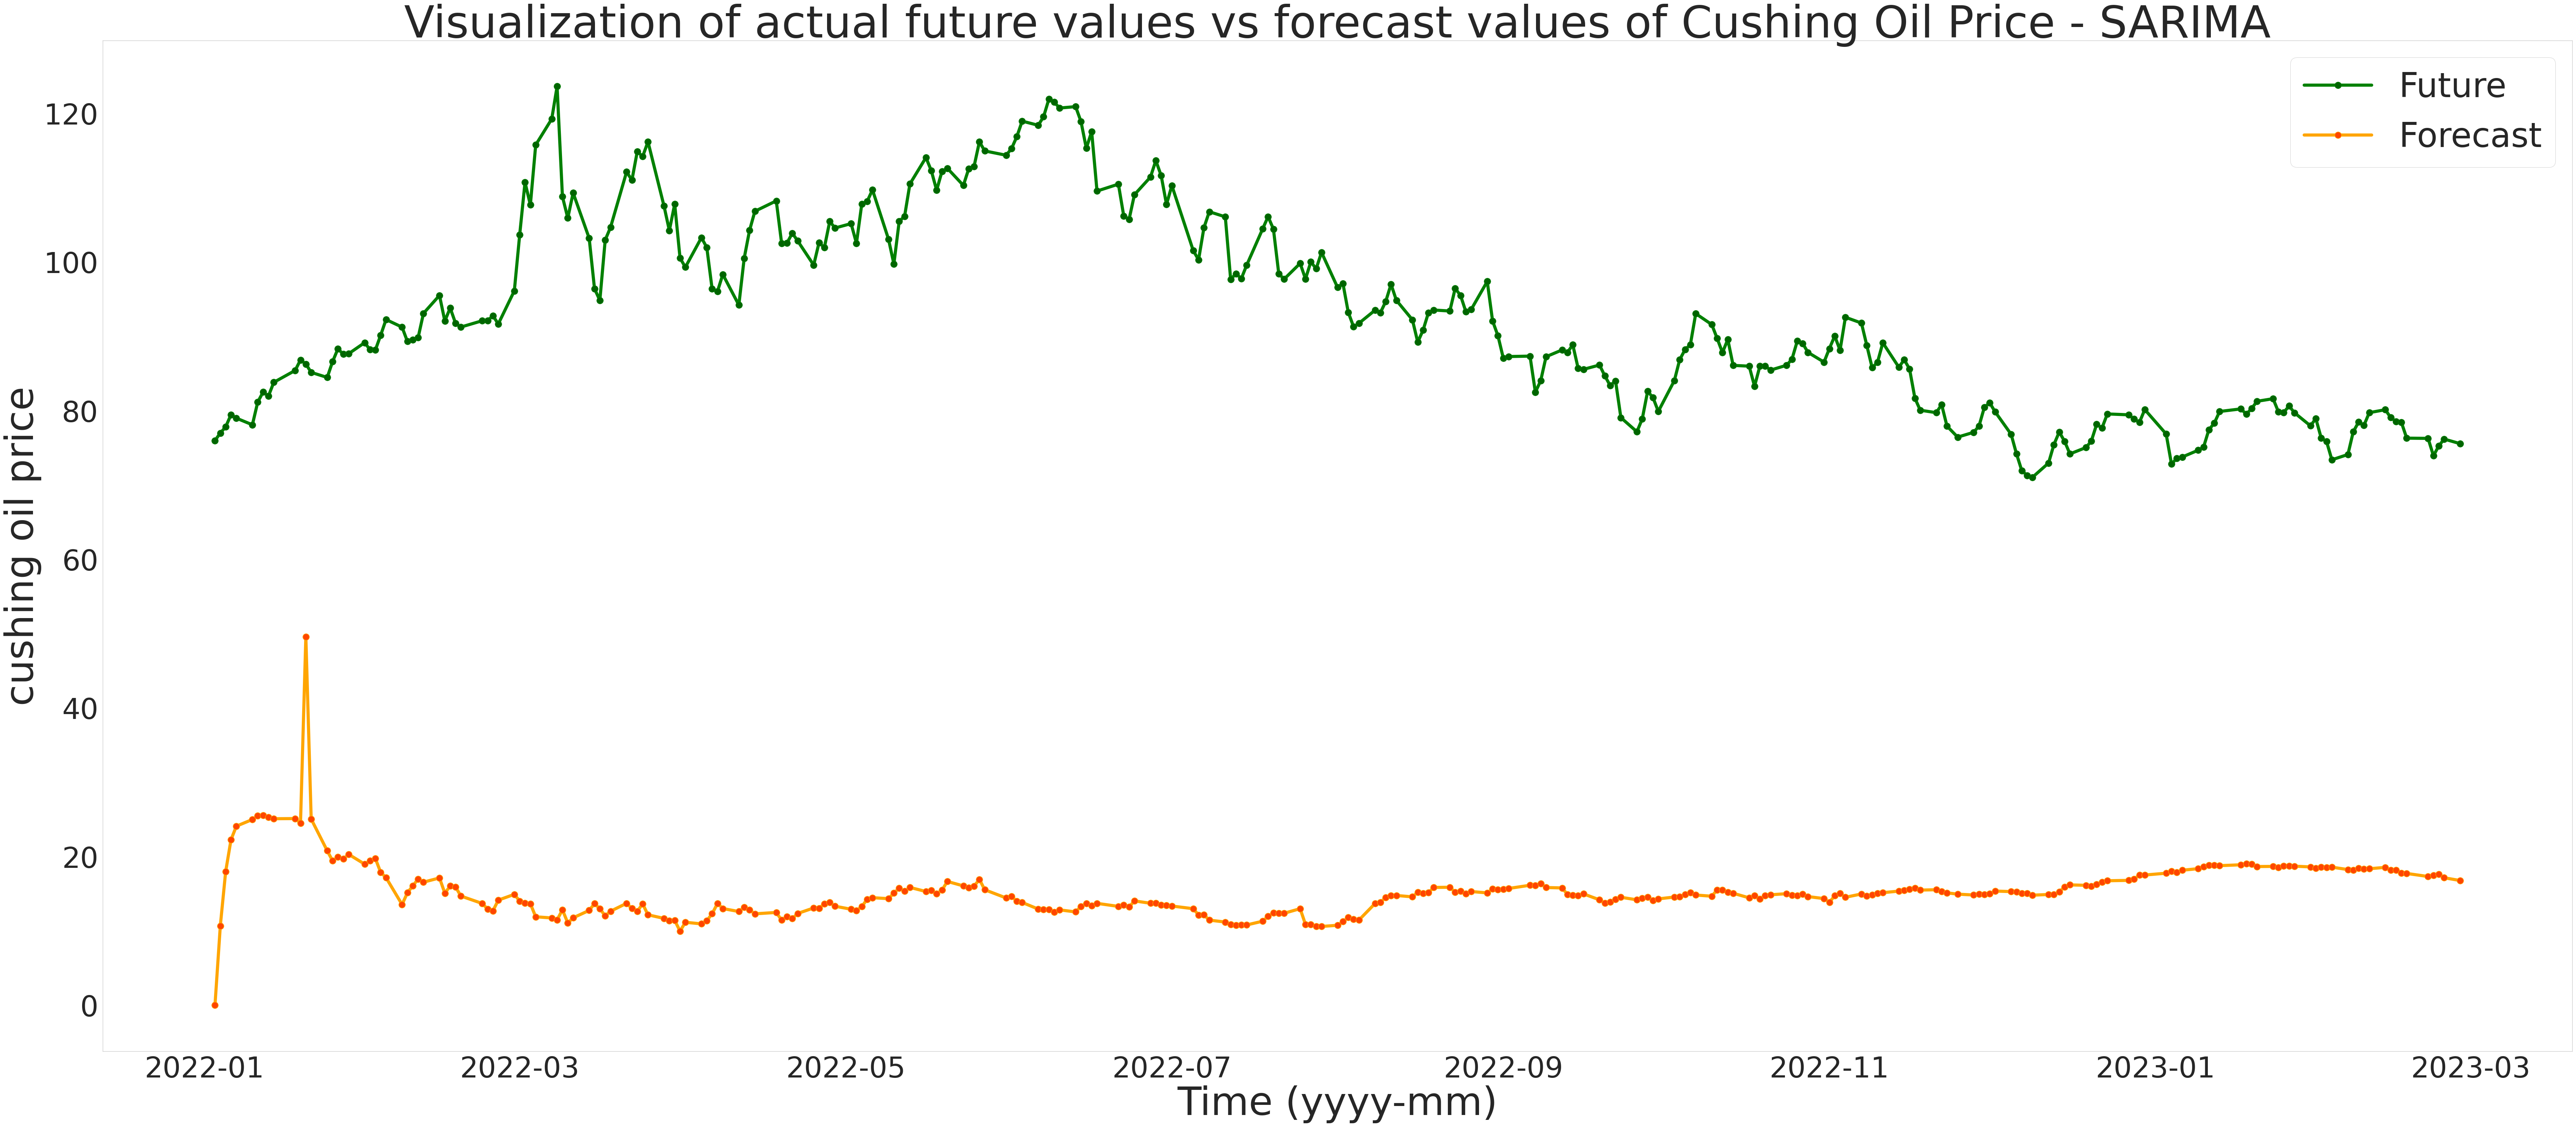

In [ ]:
# Visualisation of future value (development data) vs forecast value
fig = plt.figure(figsize=(85,35))
ax = fig.add_subplot()

plt.plot(cushing_y_future,    
         markersize=25,linewidth=6,
         markerfacecolor= 'darkgreen',
         marker='.',
        color='green',label='Future')

plt.plot(cushing_y_forecast_sarima['Predictions'],    
         markersize=25,linewidth=6,
         markerfacecolor= 'orangered',
         marker='.',
        color='orange',label='Forecast')

#plt.fill_between(y_forecast.index, y_forecast, y_future,color=(0.6,0.6,0.6))
plt.legend(fontsize=65)
plt.grid()
plt.xlabel('Time (yyyy-mm)', fontsize= 75)
plt.ylabel('cushing oil price', fontsize= 75)
plt.title('Visualization of actual future values vs forecast values of Cushing Oil Price - SARIMA', fontsize=85)
plt.yticks(fontsize=55)
plt.xticks(fontsize=55)
# plt.savefig('forecast_future.png')

Text(0.5, 1.0, 'WTI crude oil price prediction using SARIMA for 22 days.')

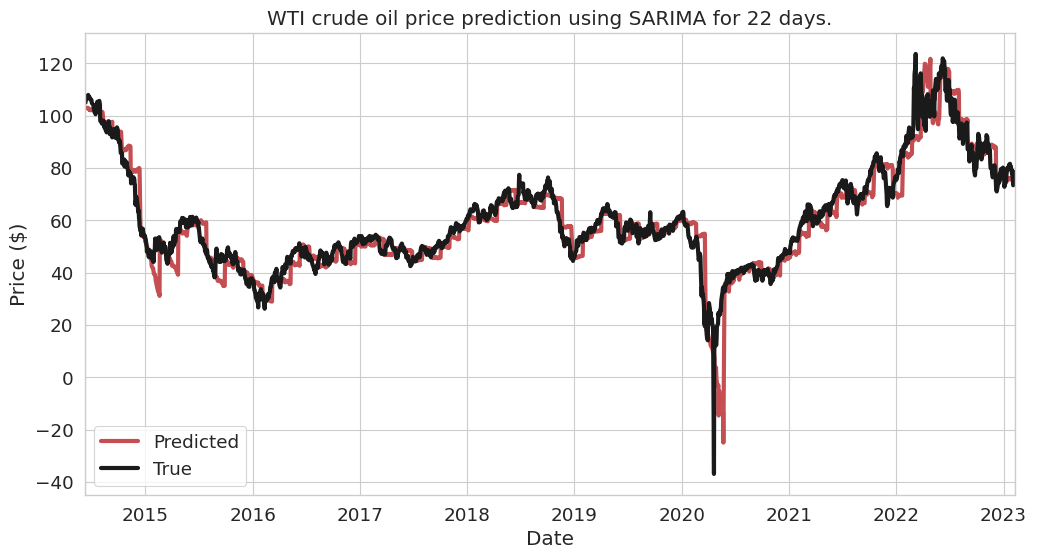

In [ ]:
## Visualization of the CV SARIMA model prediction on the training data, development and test data

pd.concat(sarima_preds_df[303:]).plot(figsize=(12,6),lw=3,color=['r','k'])
plt.legend(('Predicted','True'))
plt.ylabel('Price ($)')
plt.title(f'WTI crude oil price prediction using SARIMA for 22 days.')

In [ ]:
pd.concat(sarima_preds_df).to_csv('/content/drive/MyDrive/PCDS_OilPricePrediction/forecasting_products/sarima/cushing_cv_predictions.csv')

In [ ]:
cushing_cv_rmse = []
cushing_cv_mse = []
for df in sarima_preds_df:
  cushing_cv_rmse.append(mean_squared_error(df['Price'],df['Predictions'],squared=False))
  cushing_cv_mse.append(mean_squared_error(df['Price'],df['Predictions'],squared=True))

cv_metrics_df = {}
cv_metrics_df['cushing_cv_forecast_rmse'] = cushing_cv_rmse
cv_metrics_df['cushing_cv_forecast_mse'] = cushing_cv_mse
cv_metrics_df = pd.DataFrame.from_dict(cv_metrics_df,orient='index')
cv_metrics_df.to_csv('/content/drive/MyDrive/PCDS_OilPricePrediction/forecasting_products/sarima/cushing_sarima_cv_metrics.csv')
cv_metrics_df

,0,1,2,3,4,5,6,7,8,9,...,392,393,394,395,396,397,398,399,400,401
cushing_cv_forecast_rmse,0.955992,0.865041,0.668797,1.084604,0.262142,1.521775,0.546980,0.741670,1.348865,0.659719,...,14.524673,10.670952,6.043212,8.838610,5.565712,5.016417,3.230634,7.540899,2.756997,3.430302
cushing_cv_forecast_mse,0.913921,0.748296,0.447290,1.176366,0.068718,2.315798,0.299187,0.550074,1.819436,0.435229,...,210.966132,113.869208,36.520413,78.121033,30.977153,25.164440,10.436994,56.865162,7.601035,11.766969


In [ ]:
cv_metrics_df.mean(axis=1)

cushing_cv_forecast_rmse     3.238771
cushing_cv_forecast_mse     22.160300
dtype: float64

## Brent Data

### 0) SARIMA

In [ ]:
# Error calclulation on cross validated development set

brent_error_sarima = np.sqrt(np.average(brent_cv_score_sarima))
brent_error_sarima

4.367747663308461

In [ ]:
# get predictions on the test data(future data)

brent_y_forecast_sarima = pd.DataFrame(index=brent_y_future.index)
pred = brent_sarima_results.get_prediction(start=0,end=291,alpha=0.05,dynamic=False)
temp_pred = pred.predicted_mean
brent_y_forecast_sarima['Predictions']=temp_pred.values

In [ ]:
brent_y_future.index = brent_y_future.index.to_timestamp()

In [ ]:
brent_y_forecast_sarima['price'] = brent_y_future
brent_y_forecast_sarima.to_csv('/content/drive/MyDrive/PCDS_OilPricePrediction/forecasting_products/sarima/brent_predictions.csv')

In [ ]:
metrics_df['brent_forecast_rmse'] = mean_squared_error(brent_y_forecast_sarima['price'],brent_y_forecast_sarima['Predictions'],squared=False)
metrics_df['brent_forecast_mse'] = mean_squared_error(brent_y_forecast_sarima['price'],brent_y_forecast_sarima['Predictions'],squared=True)
metrics_df = pd.DataFrame.from_dict(metrics_df,orient='index')
metrics_df.rename(columns={0:'metric values'},inplace=True)
metrics_df.to_csv('/content/drive/MyDrive/PCDS_OilPricePrediction/forecasting_products/sarima/sarima_forecast_metrics.csv')
metrics_df

,metric values
cushing_forecast_rmse,78.792803
cushing_forecast_mse,6208.305768
brent_forecast_rmse,82.199233
brent_forecast_mse,6756.713951


(array([18993., 19052., 19113., 19174., 19236., 19297., 19358., 19417.]),
 [Text(18993.0, 0, '2022-01'),
  Text(19052.0, 0, '2022-03'),
  Text(19113.0, 0, '2022-05'),
  Text(19174.0, 0, '2022-07'),
  Text(19236.0, 0, '2022-09'),
  Text(19297.0, 0, '2022-11'),
  Text(19358.0, 0, '2023-01'),
  Text(19417.0, 0, '2023-03')])

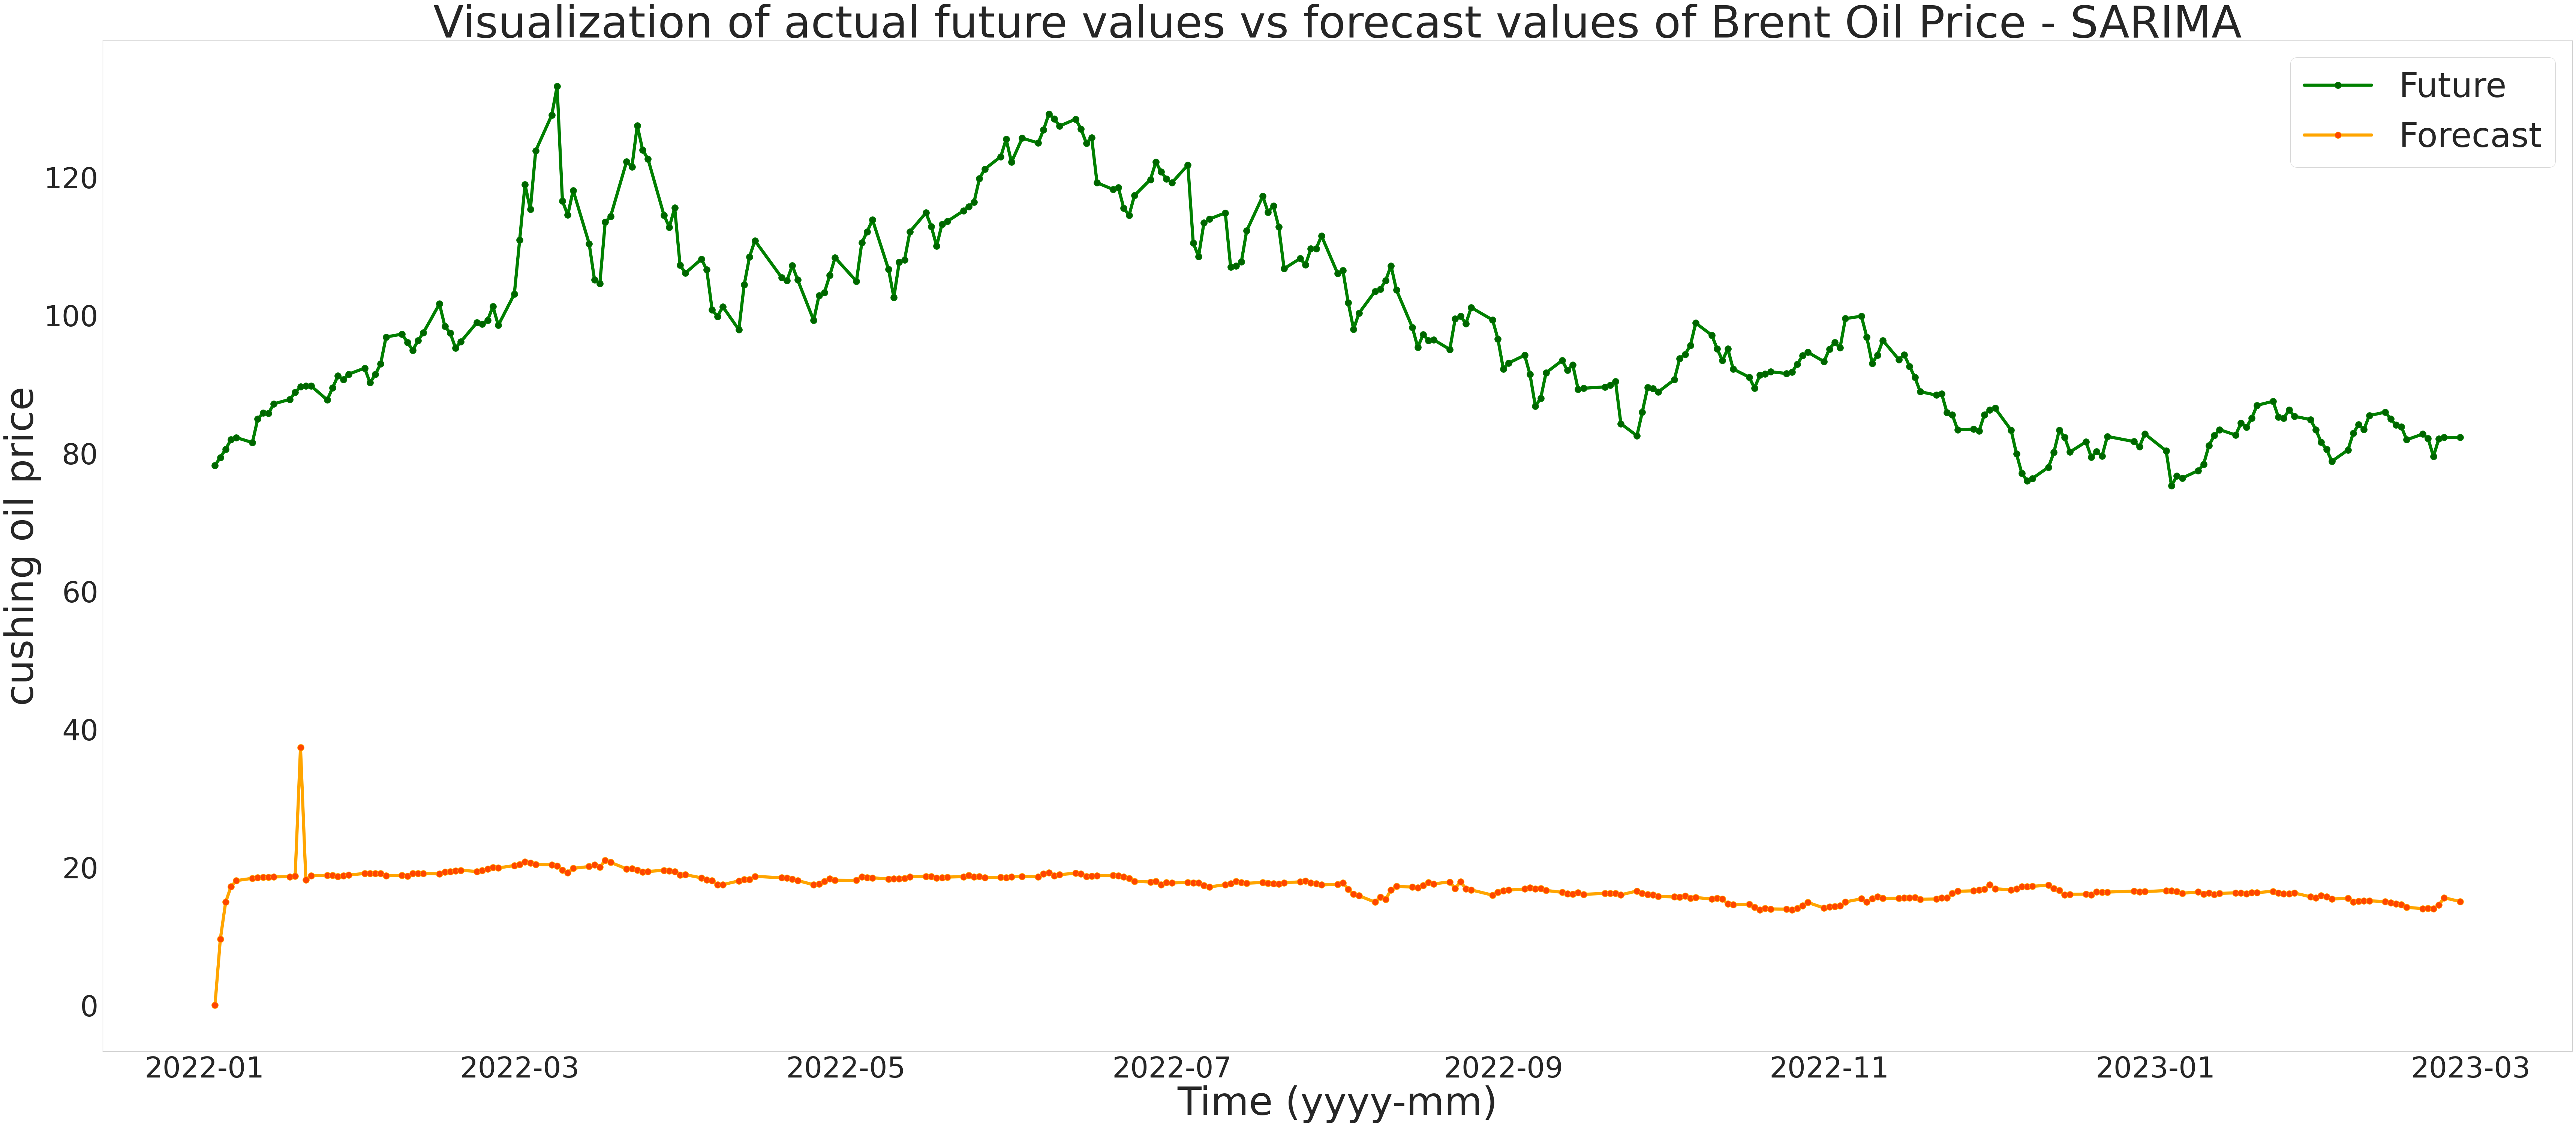

In [ ]:
# Visualisation of future value (development data) vs forecast value
fig = plt.figure(figsize=(85,35))
ax = fig.add_subplot()

plt.plot(brent_y_future,    
         markersize=25,linewidth=6,
         markerfacecolor= 'darkgreen',
         marker='.',
        color='green',label='Future')

plt.plot(brent_y_forecast_sarima['Predictions'],    
         markersize=25,linewidth=6,
         markerfacecolor= 'orangered',
         marker='.',
        color='orange',label='Forecast')

#plt.fill_between(y_forecast.index, y_forecast, y_future,color=(0.6,0.6,0.6))
plt.legend(fontsize=65)
plt.grid()
plt.xlabel('Time (yyyy-mm)', fontsize= 75)
plt.ylabel('cushing oil price', fontsize= 75)
plt.title('Visualization of actual future values vs forecast values of Brent Oil Price - SARIMA', fontsize=85)
plt.yticks(fontsize=55)
plt.xticks(fontsize=55)
# plt.savefig('forecast_future.png')

Text(0.5, 1.0, 'Brent crude oil price prediction using SARIMA for 22 days.')

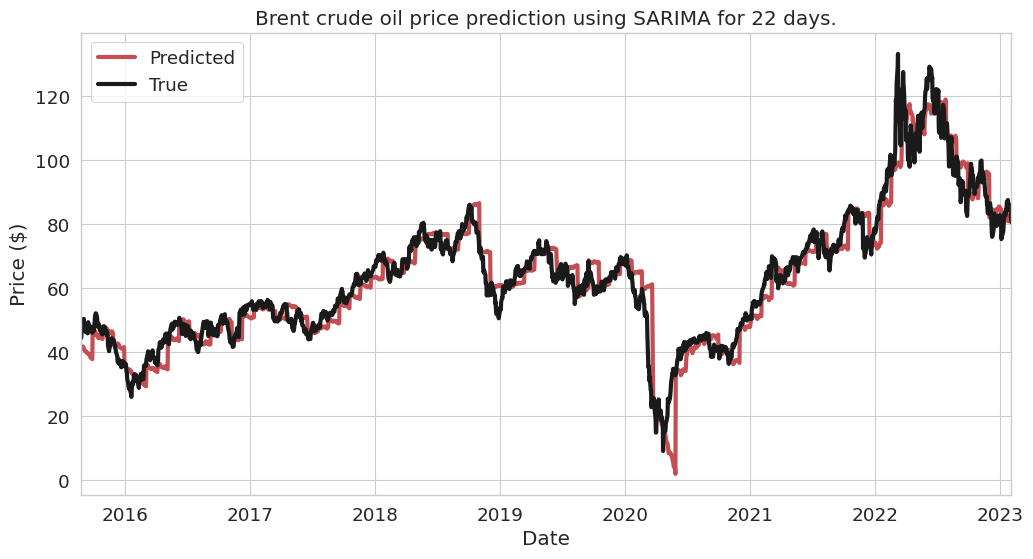

In [ ]:
## Visualization of the CV SARIMA model prediction on the training data, development and test data

pd.concat(brent_sarima_preds_df[303:]).plot(figsize=(12,6),lw=3,color=['r','k'])
plt.legend(('Predicted','True'))
plt.ylabel('Price ($)')
plt.title(f'Brent crude oil price prediction using SARIMA for 22 days.')

In [ ]:
brent_cv_rmse = []
brent_cv_mse = []
for df in brent_sarima_preds_df:
  brent_cv_rmse.append(mean_squared_error(df['Price'],df['Predictions'],squared=False))
  brent_cv_mse.append(mean_squared_error(df['Price'],df['Predictions'],squared=True))

cv_metrics_df = {}
cv_metrics_df['brent_cv_forecast_rmse'] = brent_cv_rmse
cv_metrics_df['brent_cv_forecast_mse'] = brent_cv_mse
cv_metrics_df = pd.DataFrame.from_dict(cv_metrics_df,orient='index')
cv_metrics_df.to_csv('/content/drive/MyDrive/PCDS_OilPricePrediction/forecasting_products/sarima/brent_sarima_cv_metrics.csv')
cv_metrics_df

,0,1,2,3,4,5,6,7,8,9,...,379,380,381,382,383,384,385,386,387,388
brent_cv_forecast_rmse,0.935153,1.139664,0.838929,0.595009,0.782392,0.249174,0.743885,2.011937,0.499375,1.177704,...,9.600586,4.785854,8.027050,6.868702,6.837368,8.597174,4.737963,6.377704,4.432741,3.233153
brent_cv_forecast_mse,0.874510,1.298834,0.703802,0.354036,0.612138,0.062088,0.553365,4.047889,0.249376,1.386986,...,92.171248,22.904395,64.433524,47.179067,46.749607,73.911403,22.448291,40.675106,19.649197,10.453281


In [ ]:
cv_metrics_df.mean(axis=1)

brent_cv_forecast_rmse     3.288388
brent_cv_forecast_mse     21.084806
dtype: float64

# Results:

The models that we have built using SARIMA in this notebook have error metrics much lower than the baseline model indicating that these models are learning much better than just predicting the mean of the samples over time.

However the results of SARIMA are still in terms of error metric used is still more than the ARIMA model built using the Auto Arima libray.

Hence if we choose to build ensemble models the model that would represent the ARMA family of models would be the ARIMA model. 

It is noteworthy that the difference between the error metric between auto-ARIMA and SARIMA is not much in the development set, however the Auto ARIMA is also able to keep the error at much lowere level compared to SARIMA in the test results too. 

Eventhough it is not advisable to look at the test results to make a decision, in our decicion cross validation is carried out on a much smaller time frame to allow maximum time and data for the model to learn and the prediction is on a much bigger hosrizon. 

Hence, as we do not have a separate test set to test our model we also make sure to test the model for robustness and adjust accordingly.

ALso cross validation is not allowed in some librayres externally.
